In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.linear_model import LinearRegression

Импортируем все необходимые датасеты

In [2]:
data = pd.read_csv("data\\data.csv")
bacterial_descriptors = pd.read_csv("data\\bacterial_descriptors.csv")
drug_descriptors = pd.read_csv("data\\drug_descriptors.csv")

Удалим артефакты

In [3]:
data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
drug_descriptors.drop(columns=['Unnamed: 0'], inplace=True)

Приведём названия столбцов к нижнему регистру

In [4]:
data.columns = data.columns.str.lower()
drug_descriptors.columns = drug_descriptors.columns.str.lower()
bacterial_descriptors.columns = bacterial_descriptors.columns.str.lower()

Объединим все датасеты в один

In [81]:
merged_df = data.merge(drug_descriptors, how='inner', on='drug')
merged_df = merged_df.merge(bacterial_descriptors, how='inner', on='bacteria')

Целевая переменная zoi_drug_np не должна содержать NaN значения для успешного обучения моделей, а значит необходимо оставить только непустые строки в столбце zoi_drug_np

In [82]:
merged_df = merged_df[~merged_df.zoi_drug_np.isna()]

In [83]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472 entries, 0 to 525
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   bacteria                                     472 non-null    object 
 1   np_synthesis                                 472 non-null    object 
 2   drug                                         472 non-null    object 
 3   drug_class_drug_bank                         472 non-null    object 
 4   drug_dose                                    374 non-null    float64
 5   np_concentration                             368 non-null    object 
 6   np size_min                                  472 non-null    float64
 7   np size_max                                  472 non-null    float64
 8   np size_avg                                  472 non-null    float64
 9   shape                                        472 non-null    object 
 10  me

Удалим аномальные значения fold_increase_in_antibacterial_activity (%), которые больше 100

In [84]:
merged_df.rename(columns = {'fold_increase_in_antibacterial_activity (%)': 'antibacterial_activity'}, inplace = True)

In [85]:
merged_df = merged_df[merged_df['antibacterial_activity'] <= 100]
merged_df.reset_index(inplace = True)

Удалим столбцы с большим количеством пропусков

In [88]:
merged_df.drop(columns=['subkingdom', 'clade'], inplace=True)
merged_df.drop(columns=['np_concentration', 'drug_dose', 'zoi_drug', 'zoi_np'], inplace=True)

Удалим высокоскоррелированные призанки

<AxesSubplot:>

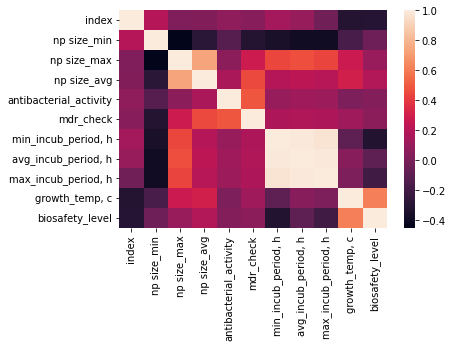

In [89]:
sns.heatmap(merged_df.corr())

In [90]:
merged_df.drop(columns=['min_incub_period, h', 'max_incub_period, h', 'np size_avg'], inplace=True)

<AxesSubplot:>

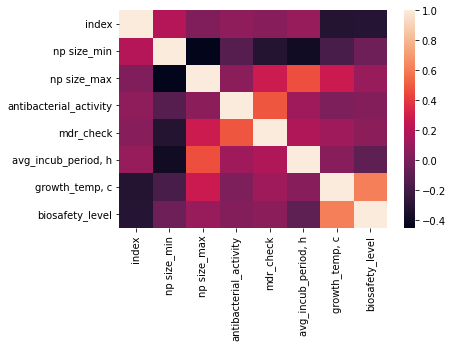

In [91]:
sns.heatmap(merged_df.corr())

Проверим результат очистки 

In [92]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   330 non-null    int64  
 1   bacteria                330 non-null    object 
 2   np_synthesis            330 non-null    object 
 3   drug                    330 non-null    object 
 4   drug_class_drug_bank    330 non-null    object 
 5   np size_min             330 non-null    float64
 6   np size_max             330 non-null    float64
 7   shape                   330 non-null    object 
 8   method                  330 non-null    object 
 9   zoi_drug_np             330 non-null    object 
 10  antibacterial_activity  330 non-null    float64
 11  mdr_check               330 non-null    int64  
 12  chemid                  330 non-null    object 
 13  prefered_name           330 non-null    object 
 14  smiles                  330 non-null    ob

Для удобства создадим копию очищенного датасета

In [93]:
cleaned_df = merged_df.copy()

Найдём артефактные значения и попробуем их поправить

In [94]:
cleaned_df.drug_class_drug_bank.value_counts()

Lactams                                               74
Carboxylic acids and derivatives                      56
Organooxygen compounds                                48
Tetracyclines                                         24
Aminoglycosides                                       20
Benzene and substituted derivatives                   17
Phenol ethers                                         17
Azolidines                                            13
\r\nOrganooxygen compounds                            13
\r\nDiazanaphthalenes                                 13
NC                                                    13
Macrolactams                                          10
\r\nQuinolines and derivatives                         8
Benzene and substituted derivatives; Phenol ethers     2
\r\nSteroids and steroid derivatives                   2
Name: drug_class_drug_bank, dtype: int64

Среди адекватных значений встречаются значения с "\r\n". Исправим их

In [95]:
cleaned_df.drug_class_drug_bank = cleaned_df.drug_class_drug_bank.str.replace("\r\n", "")
cleaned_df.drug_class_drug_bank = cleaned_df.drug_class_drug_bank.str.replace("\r", "")
cleaned_df.drug_class_drug_bank = cleaned_df.drug_class_drug_bank.str.replace("\n", "")

В столбце kingdom содержится одно единственное значение, а значит оно не имеет веса в дальнейшем обучении моделей.

In [96]:
cleaned_df['kingdom'].value_counts()

Bacteria    330
Name: kingdom, dtype: int64

In [97]:
cleaned_df.drop(columns = ['kingdom'], inplace=True)

Проверим выбросы

In [98]:
for column in cleaned_df.select_dtypes(include=np.number).columns:
    fig = px.box(
        data_frame = cleaned_df,
        y = column
    )
    fig.show()

Удалим выбросы

In [99]:
cleaned_df.drop(columns=['mdr_check', 'biosafety_level'], inplace=True)
cleaned_df = cleaned_df[cleaned_df['np size_max'] < 69]
cleaned_df = cleaned_df[cleaned_df['antibacterial_activity'] < 10]
cleaned_df = cleaned_df[(cleaned_df['avg_incub_period, h'] < 84) | (cleaned_df['avg_incub_period, h'] > 16)]

Проверим какие значения может принимать целевая переменная

In [106]:
cleaned_df.zoi_drug_np.sample(10)

2        12
129      17
267      34
244      17
206      19
270      16
75       27
306    17+2
41       16
88       13
Name: zoi_drug_np, dtype: object

Данный признак может содержать значения в виде "17+2" или же "32+". Исправим это

In [107]:
def convert_to_numeric(value):
    try:
        return float(value)
    except:
        try:
            return eval(value)
        except:
            return value 

cleaned_df['zoi_drug_np'] = cleaned_df['zoi_drug_np'].apply(convert_to_numeric)
cleaned_df['zoi_drug_np'] = cleaned_df['zoi_drug_np'].replace('32+', '32')

In [108]:
cleaned_df.zoi_drug_np = cleaned_df.zoi_drug_np.astype(float)
cleaned_df.zoi_drug_np.min()

7.0

In [109]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328 entries, 0 to 329
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   328 non-null    int64  
 1   bacteria                328 non-null    object 
 2   np_synthesis            328 non-null    object 
 3   drug                    328 non-null    object 
 4   drug_class_drug_bank    328 non-null    object 
 5   np size_min             328 non-null    float64
 6   np size_max             328 non-null    float64
 7   shape                   328 non-null    object 
 8   method                  328 non-null    object 
 9   zoi_drug_np             328 non-null    float64
 10  antibacterial_activity  328 non-null    float64
 11  chemid                  328 non-null    object 
 12  prefered_name           328 non-null    object 
 13  smiles                  328 non-null    object 
 14  tax_id                  328 non-null    ob

Мы не разобрались как пользоваться базой данных для бактерий, поэтому не будем брать информацию по ID в дальнейшее рассмотрение

In [110]:
cleaned_df.drop(columns = ['tax_id'], inplace = True)

Добавим дополнительную информацию по данным нам ID

In [120]:
molecule_id = cleaned_df.chemid

oral = []
parenteral = []
chirality = []

for mol_id in molecule_id:
    m = molecule.filter(chembl_id = mol_id)[0]
    oral.append(m['oral'])
    parenteral.append(m['parenteral'])
    chirality.append(m['chirality'])

In [134]:
cleaned_df['oral'] = oral
cleaned_df['parenteral'] = parenteral
cleaned_df['chirality'] = chirality

In [138]:
cleaned_df["num_radical_electrons"] = pd.Series(np.array([Descriptors.NumRadicalElectrons(Chem.MolFromSmiles(i)) for i in cleaned_df["smiles"]]), index=cleaned_df.index)

In [143]:
cleaned_df.drop(columns = ['index', 'chemid', 'smiles'], inplace = True)

Сохраняем датасет в новый файл

In [146]:
cleaned_df.to_csv("data\\cleaned_data.csv")